# Study the transient list, following Transient Analysis notebook
Read in csv file generated by that document

In [1]:
%matplotlib inline
from uw.like2.analyze import (transientinfo, )
from skymaps import SkyDir
map( reload, (transientinfo,))
os.chdir(os.path.expandvars('$FERMI/skymodels'))
df = pd.read_csv('P301_monthly/transients.csv', index_col=0)
print 'Read in {} sources'.format(len(df))
hilat = np.abs(df.glat)>10
print 'High latitude subset (10 deg) {}'.format(sum(hilat))

Read in 29881 sources
High latitude subset (10 deg) 21345


In [2]:
#df.ix[0]

## Get flux density from the pixel at the location
Read the KDE file for 6 years. Need to select the pixels with |b|>10

In [3]:
from uw.like2.pub import healpix_map as hpm
filename=os.path.expandvars('$FERMI/skymodels/P301_6years/uw972/hptables_ts_kde_512.fits')
kde6 = hpm.FromFITS(filename,'kde')


In [4]:
from skymaps import Band, SkyDir
hphilat = np.array([abs(Band(512).dir(i).b())>10 for i in range(12*512**2)],bool)
sum(hphilat)
                                       

2598912

In [5]:
skydirs = map(SkyDir, df.ra, df.dec)
df['fluxdens'] = map(kde6, skydirs)
df.fluxdens.describe()

count    2.988100e+04
mean     4.128028e+06
std      1.685595e+07
min      2.409061e+05
25%      6.286438e+05
50%      1.106801e+06
75%      2.754873e+06
max      7.741478e+08
dtype: float64

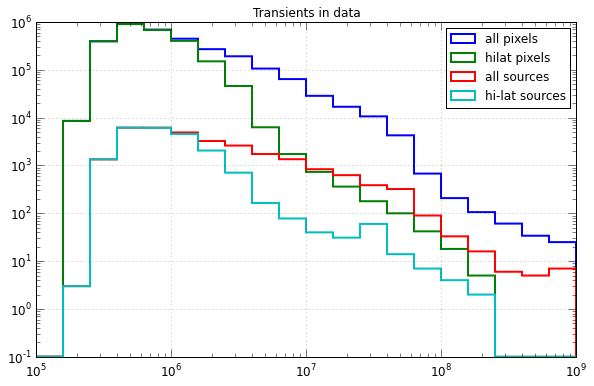

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
histkw = dict(bins=np.logspace(5,9, 21), histtype='step', lw=2,log=True)
ax.hist(kde6.vec, label='all pixels', **histkw)
ax.hist(kde6.vec[hphilat], label='hilat pixels', **histkw)
ax.hist(df.fluxdens, label='all sources',  **histkw)
ax.hist(df.fluxdens[hilat], label='hi-lat sources', **histkw)

ax.grid(True, alpha=0.5)
ax.legend()
plt.setp(ax, xscale='log', title='Transients in data');

### Now look at a MC KDE and the MC sources
Load the kde for each month, sum the vectors, scale to 6 years

In [18]:
import glob
fitsnames=glob.glob(os.path.expandvars('$FERMI/skymodels/obssim_monthly/omonth*/hptables_ts_kde_512.fits'))
kdesims = [hpm.FromFITS(fitsname, 'kde') for fitsname in fitsnames]

In [14]:
simvec =kdesims.sum(axis=0)/kdesims.shape[0]*72
simvec.min()

146540.7

Make a kde for the sum of the simulations

In [23]:
kdesim = hpm.HParray('kdesim6years', simvec)

Get the locations of the obssim transients and the corresponding flux values

In [25]:
obsfile = 'obssim_monthly/obssim_transients.csv'
dfobs = pd.read_csv(obsfile, index_col=0)
print 'Read in {} sources from {}'.format(len(dfobs), obsfile)
hilatobs = np.abs(dfobs.glat)>10
print 'High latitude subset (10 deg) {}'.format(sum(hilatobs))
skydirs = map(SkyDir, dfobs.ra, dfobs.dec)
dfobs['fluxdens'] = map(kdesim, skydirs)
obshilat = np.abs(dfobs.glat)>10
dfobs.fluxdens.describe()

Read in 3507 sources from obssim_monthly/obssim_transients.csv
High latitude subset (10 deg) 2382


count    3.507000e+03
mean     3.460113e+06
std      7.324303e+06
min      3.324880e+05
25%      8.362501e+05
50%      1.434961e+06
75%      3.279959e+06
max      1.581937e+08
dtype: float64

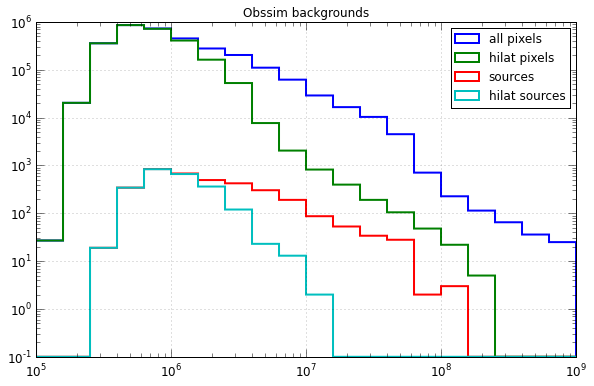

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
histkw = dict(bins=np.logspace(5,9, 21), histtype='step', lw=2,log=True)
ax.hist(simvec, label='all pixels', **histkw)
ax.hist(simvec[hphilat], label='hilat pixels', **histkw)
factor = 1
ax.hist(dfobs.fluxdens*factor, label='sources', **histkw)
ax.hist(dfobs.fluxdens[obshilat]*factor, label='hilat sources', **histkw)
ax.grid(True, alpha=0.5)
ax.legend()
plt.setp(ax, xscale='log', title='Obssim backgrounds');

### Make ratios of fractions of pixels with sources

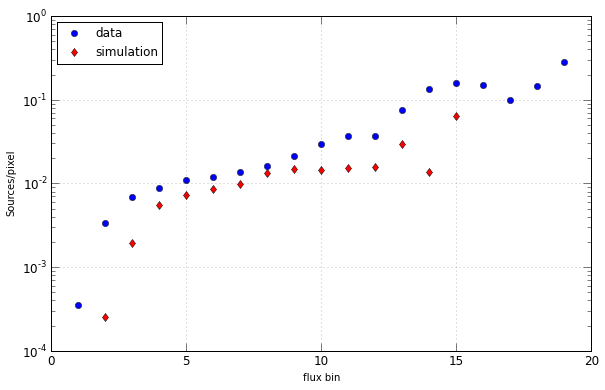

In [59]:
# data
bins=histkw['bins']
data_pixels= np.histogram(kde6.vec, bins)[0]
data_sources=np.histogram(df.fluxdens,bins)[0]
data_ratio =data_sources/np.array(data_pixels, float)
# MC
sim_pixels = np.histogram(simvec, bins)[0] 
simfactor = 72./15.
sim_sources = np.histogram(dfobs.fluxdens,bins)[0] * simfactor
sim_ratio = sim_sources / np.array(sim_pixels, float)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(data_ratio, 'o', label='data')
ax.plot(sim_ratio, 'dr', label='simulation')
plt.setp(ax, yscale='log', ylabel='Sources/pixel', xlabel='flux bin')
ax.grid(True, alpha=0.5)
ax.legend(loc='upper left')

In [45]:
float(len(kde6.vec))* 0.003/72

131.072

In [58]:
pdf = pd.DataFrame([data_pixels, data_sources, data_ratio, sim_pixels, sim_sources, sim_ratio],
            index='data_pix data_src data_ratio sim_pix sim_src sim_ratio'.split()
            ).T
factor = float(len(kde6.vec))/72
pdf['signal'] = (pdf.data_ratio - pdf.sim_ratio)* factor
pdf['data_error']  = np.sqrt(pdf.data_src)/pdf.data_pix * factor
simfactor = 72/15. 
pdf['sim_error']   = np.sqrt(pdf.sim_src/simfactor)*
pdf[2:10]

,data_pix,data_src,data_ratio,sim_pix,sim_src,sim_ratio,signal,data_error
2,395840,1343,0.003393,359169,91.2,0.000254,137.139126,4.044893
3,905728,6176,0.006819,861942,1651.2,0.001916,214.221895,3.790919
4,693814,6182,0.008910,731964,4041.6,0.005522,148.049580,4.951196
5,447567,4901,0.010950,453454,3264.0,0.007198,163.937508,6.833968
6,270467,3247,0.012005,279440,2380.8,0.008520,152.273530,9.204825
7,191967,2609,0.013591,204327,2035.2,0.009961,158.613422,11.625165
8,106238,1737,0.016350,110898,1459.2,0.013158,139.462564,17.139916
9,64035,1353,0.021129,62328,916.8,0.014709,280.484909,25.096904


Looks like 0.3% occupancy per pixel, or 

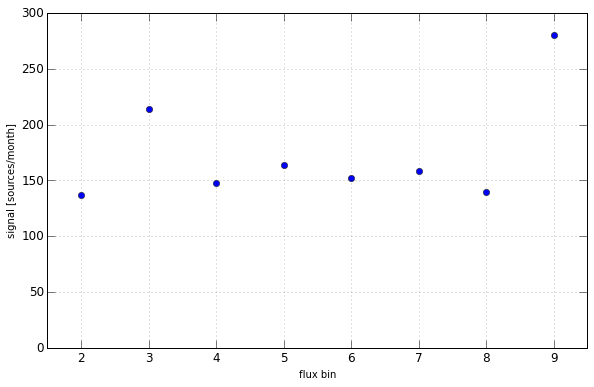

In [56]:
fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(range(2,10), pdf.signal[2:10], fmt='o', )
plt.setp(ax, ylim=(0, 300), xlim=(1.5, 9.5), xlabel='flux bin',ylabel='signal [sources/month]' )
ax.grid(True, alpha=0.5)


In [51]:
plt.errorbar?